In [1]:
import pandas as pd
import time
import math
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import pickle
import sys

"""
Some global parameters to be tuned here.
"""
date_range = ("2016-01-01T00:00:00", "2016-03-31T23:59:59")

time_start = int(time.mktime(time.strptime(date_range[0], '%Y-%m-%dT%H:%M:%S')))
time_end = int(time.mktime(time.strptime(date_range[1], '%Y-%m-%dT%H:%M:%S')))

# TODO: def foo()
# 7 days as a period
period = 604800.0
n_period = int(math.ceil((time_end - time_start)/(period)))



def save_obj(obj, name):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

def time_str2int(in_time):
    return int(time.mktime(time.strptime(in_time, '%Y-%m-%d %H:%M:%S'))) 

def string2list(in_str):
    ret = in_str.split('],[')
    temp = []
    for each in ret:
        temp.append(each.strip('[').strip(']').split(','))
    return temp
    #return pd.DataFrame(temp)

def get_uuids(filename):
    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    grouped_by_uuid = data_all.groupby([0])
    uuids = grouped_by_uuid.groups.keys()

    return uuids

# def get_uids(userbase_dataframe, uuid_list):
#     # TODO
#     u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
#     u_by_uuid = u_by_uuid[u_by_uuid[1]!= 'cfcd208495d565ef66e7dff9f98764da']
#     return u_by_uuid[0].unique()

def get_eventids(filename):
    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    grouped_by_eventid = data_all.groupby([1])
    eventids = grouped_by_eventid.groups.keys()
    return eventids

def get_uuid2uid(userbase_dataframe, uuid_list):
    # TODO
    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    u_by_uuid = u_by_uuid[u_by_uuid[1]!= 'cfcd208495d565ef66e7dff9f98764da']
    uuid2uid = {}
    for each in u_by_uuid.iterrows():
        if each[1][1] not in uuid2uid:
            uuid2uid[each[1][1]] = []
        uuid2uid[each[1][1]].append(each[1][0])
    return uuid2uid

def get_uid2uuid(userbase_dataframe, uuid_list):
    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    u_by_uuid = u_by_uuid[u_by_uuid[1]!= 'cfcd208495d565ef66e7dff9f98764da']
    uid2uuid = {}
    for each in u_by_uuid.iterrows():
        if each[1][0] not in uid2uuid:
            uid2uuid[each[1][0]] = []
        uid2uuid[each[1][0]].append(each[1][1])
    return uid2uuid

def feature_expenditure(filename, userbase_dataframe, uuid_list):

    uid2uuid = get_uid2uuid(userbase_dataframe, uuid_list)
    for each in uid2uuid:
        if len(uid2uuid[each]) > 1:
            print "Found one-to-many uid to uuid relationship, but I ignored it for simplicity."

    e = pd.read_csv(filename, sep='\t', header = None)
    exp = e[e[0].isin(set(uid2uuid.keys()))]
    exp[-1] = exp[0].map(lambda x: uid2uuid[x][0])
    exp_by_uuid = exp.groupby([-1])

    expenditure_dict = {}
    for each in exp_by_uuid.groups:
        index_list = exp_by_uuid.groups[each]
        data_frame = exp.loc[index_list]
        
        reg = []
        rec = []
        pay = []
        for row in data_frame.iterrows():
            reg += string2list(row[1][1])
            rec += string2list(row[1][2])
            pay += string2list(row[1][3])
        reg = pd.DataFrame(reg)
        rec = pd.DataFrame(rec)
        pay = pd.DataFrame(pay)
        
        
        """reg"""
        reg = reg[reg[3]!='0']
        try: # no reg means no rec or pay
            #[0] #uid
            temp = [len(index_list)]
            #[1] #games
            temp.append(len(reg[0]))
            #[2] # unique games
            temp.append(len(reg[1].unique()))
            #[3] # unique cid
            temp.append(len(reg[2].unique()))
            #[4] # unique game_uid
            temp.append(len(reg[4].unique()))
            #[5] # unique ucid
            temp.append(len(reg[5].unique()))

            reg_time = reg[3].map(time_str2int)
            #[6] max reg time
            temp.append(max(reg_time))
            #[7] min reg time
            temp.append(min(reg_time))
            #[8] reg time span
            temp.append(max(reg_time) - min(reg_time))
            #[9] reg time mean
            temp.append(reg_time.quantile(0.5))
            #[10] reg time std
            temp.append(np.std(reg_time))
        except:
            continue
        
        """rec"""
        rec = rec[rec[2]!='0']
        if len(rec) == 0:
            temp += [np.nan] * 12
        else:
            #[11] # rec
            temp.append(len(rec[0]))
            #[12] # unique games
            temp.append(len(rec[0].unique()))
            #[13] # unique types
            temp.append(len(rec[1].unique()))
            #[14] # unique cid
            temp.append(len(rec[3].unique()))
            #[15] # unique item
            temp.append(len(rec[4].unique()))    
            #[16] # unique appid
            temp.append(len(rec[5].unique()))  
            #[17] # unique pay_from
            temp.append(len(rec[6].unique()))  

            rec_time = rec[2].map(time_str2int)
            #[18] max reg time
            temp.append(max(rec_time))
            #[19] min reg time
            temp.append(min(rec_time))
            #[20] reg time span
            temp.append(max(rec_time) - min(rec_time))
            #[21] reg time mean
            temp.append(rec_time.quantile(0.5))
            #[22] reg time std
            temp.append(np.std(rec_time))
        
        pay = pay[pay[2]!='0']
        if len(pay) == 0:
            temp += [np.nan] * 11
        else:
            #[23] # payments
            temp.append(len(pay[0]))
            #[24] # unique games
            temp.append(len(pay[0].unique()))
            #[25] # unique cid
            temp.append(len(pay[1].unique()))
            #[26] # unique appid
            temp.append(len(pay[3].unique()))
            #[27] # unique item
            temp.append(len(pay[4].unique()))    
            #[28] # unique porder
            temp.append(len(pay[5].unique()))  


            pay_time = pay[2].map(time_str2int)
            #[29] max reg time
            temp.append(max(pay_time))
            #[30] min reg time
            temp.append(min(pay_time))
            #[31] reg time span
            temp.append(max(pay_time) - min(pay_time))
            #[32] reg time mean
            temp.append(pay_time.quantile(0.5))
            #[33] reg time std
            temp.append(np.std(pay_time))
        
        expenditure_dict[each] = temp

    return expenditure_dict  

def feature_expenditure_old(filename, uid_list):
    """
    Input: filename-- expenditure_timeline
           uid_list-- uids to be extracted from expenditure_timeline

    Output: a dictionary of (uuid, feature) pairs

    TODO: check possible repetitions of features
    """
    e = pd.read_csv(filename, sep='\t', header = None)
    exp = e[e[0].isin(set(uid_list))]

    exp_dict = {}
    for row in exp.iterrows():
        uid = row[1][0]
        
        reg_df = string2list(row[1][1])
        rec_df = string2list(row[1][2])
        pay_df = string2list(row[1][3])
        
        temp = np.zeros(21)

        # reg
        if reg_df[3].any() == '0':
            temp[0:6] = np.nan
        else:
            temp[0] = reg_df[1].nunique()
            temp[1] = reg_df[2].nunique()
            temp[2] = max(reg_df[3].map(time_str2int))
            temp[3] = min(reg_df[3].map(time_str2int))
            temp[4] = temp[2] - temp[3]
            temp[5] = reg_df[5].nunique()

        
        # pay
        if pay_df[2].any() == '0':
            temp[6:13] = np.nan
        else:
            temp[6] = pay_df[0].nunique()
            temp[7] = pay_df[1].nunique()
            temp[8] = max(pay_df[2].map(time_str2int))
            temp[9] = min(pay_df[2].map(time_str2int))
            temp[10] = temp[8] - temp[9]
            temp[11] = pay_df[4].nunique()
            temp[12] = pay_df[5].nunique()

        
        # rec
        if rec_df[2].any() == '0':
            temp[13:21] = np.nan
        else:
            temp[13] = rec_df[0].nunique()
            temp[14] = rec_df[1].nunique()
            temp[15] = max(rec_df[2].map(time_str2int))
            temp[16] = min(rec_df[2].map(time_str2int))
            temp[17] = temp[15] - temp[16]
            temp[18] = rec_df[3].nunique()
            temp[19] = rec_df[4].nunique()
            temp[20] = rec_df[6].nunique()

        exp_dict[uid] = temp

    return exp_dict

def cleaning_filter(input_element, filter_list, replacement):
    if input_element not in filter_list:
        return replacement
    return input_element

def ucid_cleaner(input_element):
    try:
        ret = eval(input_element)
    except:
        ret = []
    if type(ret) is list:
        return ret
    elif type(ret) is dict:
        return map(lambda x: int(x), ret.values())
    elif type(ret) is int:
        return [ret]
    else:
        print "Error in ucid_cleaner"


def feature_userbase(userbase_dataframe, uuid_list):
    """
    Input: userbase_dataframe-- stacked userbases by pandas.read_csv()
           uuid_list-- -- uuids to be extracted from userbase

    Output: a dictionary of (uuid, feature) pairs
    """

    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    # remove empty uuids: 'cfcd208495d565ef66e7dff9f98764da' 
    u_by_uuid = u_by_uuid[u_by_uuid[1] != 'cfcd208495d565ef66e7dff9f98764da']
    # remove NaNs
    u_by_uuid.drop(u_by_uuid[u_by_uuid[9].isnull()].index, inplace=True)

    """Some data cleaning"""
    # clean sex
    value_counts = u_by_uuid[5].value_counts()
    u_by_uuid[5] = u_by_uuid[5].map(lambda x: cleaning_filter(x, value_counts.index[:4], value_counts.index[0]))

    # clean platform
    u_by_uuid[6] = u_by_uuid[6].map(lambda x: str(x))
    value_counts = u_by_uuid[6].value_counts()
    u_by_uuid[6] = u_by_uuid[6].map(lambda x: cleaning_filter(x, value_counts.index[:3], '0'))

    # clean status
    u_by_uuid[7] = u_by_uuid[7].map(lambda x: str(x))
    u_by_uuid[7] = u_by_uuid[7].map(lambda x: cleaning_filter(x, ['0'], '1'))

    # clean ucid
    u_by_uuid[8] = u_by_uuid[8].map(lambda x: str(x))

    """some processing about ucid"""
    # clean ucid
    u_by_uuid[10] = u_by_uuid[10].map(ucid_cleaner)
    ucids = []
    for each in u_by_uuid[10]:
        ucids += each
    dictinct_ucids = list(set(ucids))

    # Begin feature engineering
    grouped_by_u = u_by_uuid.groupby([1])
    
    userbase_dict = {}
    for each in grouped_by_u.groups:
        
        index_list = grouped_by_u.groups[each]
        data_frame = u_by_uuid.loc[index_list]
        
        try:
            #[0] uid
            temp = [len(index_list)]

            #[1] reg_ip
            temp.append(data_frame[2].nunique())

            #[2] has signature or not
            if sum(data_frame[3].isnull()) > 0:
                temp.append(1)
            else:
                temp.append(0)

            #[3] has nickname or not
            #nn = data_frame['4'].map(lambda x: x == 'None')
            if sum(data_frame[4].map(lambda x: x == 'None')) > 0:
                temp.append(1)
            else:
                temp.append(0)

            #[4] sex majority -- One-Hot needed
            temp.append(str(data_frame[5].value_counts().index[0]))
            #[5] sex unique count
            temp.append(data_frame[5].nunique())

            #[6] platform majority -- One-Hot needed
            temp.append(str(data_frame[6].value_counts().index[0]))
            #[7] platform unique count
            temp.append(data_frame[6].nunique())

            #[8] ucid majority -- One-hot
            temp.append(str(data_frame[8].value_counts().index[0]))
            #[9] ucid unique count
            temp.append(data_frame[8].nunique())

            #reg time stuff
            reg_time = data_frame[9].map(time_str2int)
            #[10] reg time max
            temp.append(max(reg_time))
            #[11] reg time min
            temp.append(min(reg_time))
            #[12] reg time span
            temp.append(max(reg_time) - min(reg_time))
            #[13] reg time mean
            temp.append(reg_time.quantile(0.5))
            #[14] reg time std
            temp.append(np.std(reg_time))


            #[15] group: number of groups
            temp.append( sum(data_frame[10].map(lambda x: len(x))) )
            #[16] group: dummy
            temp.append(int(temp[len(temp)-1] > 0))

            """TODO: a huge feature line of ucid down in the bottom"""

            #[18] name
            if sum(data_frame[11].map(lambda x: x != 'None')) > 0:
                temp.append(1)
            else:
                temp.append(0)

            #[19-25] dummy
            for i in range(12, 19):
                temp.append(int(sum(data_frame[i]) > 0))

            """the huge line promised above"""
            ucid_feature = [0] * len(dictinct_ucids)
            for i, e in enumerate(dictinct_ucids):
                if e in data_frame[10]:
                    ucid_feature[i] += 1

            temp += ucid_feature

            userbase_dict[each] = temp

        except:
            e = sys.exc_info()[0]
            print data_frame
            print e
            break

    return userbase_dict

In [2]:
def feature_event(filename):

    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    # binning whole logs in periods as a big dict()
    whole_dict = {i : {} for i in range(n_period)}
    # for each log
    for log in data_all.iterrows():
        # find its binned period
        idx = int(math.floor((log[1][2] - time_start)/period))

        if log[1][0] not in whole_dict[idx]:
            whole_dict[idx][log[1][0]] = []

        # append uuid, event id, and timestamp to the list
        whole_dict[idx][log[1][0]].append((log[1][1], log[1][2]))

    return whole_dict

In [ ]:
def feature_event_2(filename):

    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    # binning whole logs in periods as a big dict()
    whole_dict = {i : {} for i in range(n_period)}
    # for each log
    for log in data_all.iterrows():
        # find its binned period
        idx = int(math.floor((log[1][2] - time_start)/period))

        if log[1][0] not in whole_dict[idx]:
            whole_dict[idx][log[1][0]] = []

        # append uuid, event id, and timestamp to the list
        whole_dict[idx][log[1][0]].append((log[1][1], log[1][2]))

    return whole_dict

In [2]:
t = pd.read_csv('/data/yulun/timeline/timeline_event_gpapp.txt', sep='\t', header = None)
t1 = t[t[2] >= time_start]
data_all = t1[t1[2] <= time_end]

In [4]:
data_all.head()

,0,1,2
6,641ddc183e4af1108919effa9c15c6a1,1000,1453446734
7,641ddc183e4af1108919effa9c15c6a1,1000,1453446734
8,641ddc183e4af1108919effa9c15c6a1,1000,1453447188
9,641ddc183e4af1108919effa9c15c6a1,1202,1453447186
10,641ddc183e4af1108919effa9c15c6a1,1200,1453447188


In [6]:
data_all_grouped = data_all.groupby([0])

In [18]:
whole_dict_3 = {0:{}, 1:{}}
# for each in data_all_grouped.groups:
#     temp = data_all.loc[data_all_grouped.groups[each]]
boundary = time_end - period
#    temp = temp.filter(lambda x: x[2] > (boundary-period))
#   temp[2].filter(lambda x: x > (boundary-period))
for log in data_all.iterrows():
    if log[1][0] not in whole_dict_3[0]:
        whole_dict_3[0][log[1][0]] = []
    if log[1][0] not in whole_dict_3[1]:
        whole_dict_3[1][log[1][0]] = []
    if log[1][2] > boundary:
        whole_dict_3[1][log[1][0]].append((log[1][1], log[1][2]))
    else:
        whole_dict_3[0][log[1][0]].append((log[1][1], log[1][2]))


In [30]:
grouped = data_all.groupby([0])

In [39]:
duration = {}
for each in grouped.groups:
    idx = grouped.groups[each]
    duration[each] = max(data_all.loc[idx][2]) - min(data_all.loc[idx][2])

### log中每个uuid的活跃时间长度分布

In [40]:
dur = pd.DataFrame(duration.values())

In [42]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9fd04fbd0>]], dtype=object)

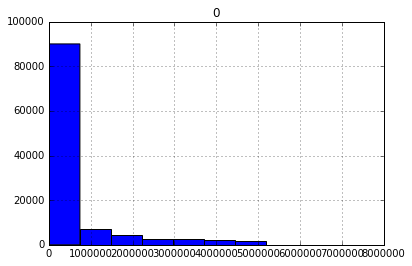

In [43]:
dur.hist()

#### 活跃时间小于一天的分布

In [75]:
dur_zoom = pd.DataFrame(filter(lambda x: x>=0 and x<86400,duration.values()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9fc345dd0>]], dtype=object)

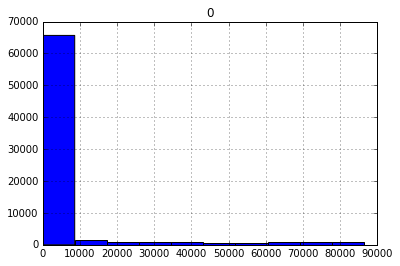

In [76]:
dur_zoom.hist()

#### 活跃时间大于一天的分布

In [77]:
dur_zoom = pd.DataFrame(filter(lambda x: x>=86400,duration.values()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9fc160910>]], dtype=object)

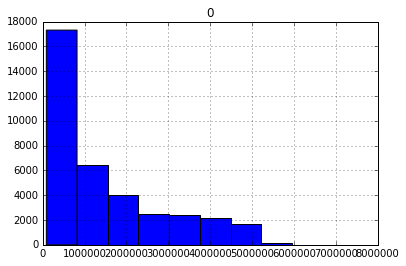

In [78]:
dur_zoom.hist()

#### 活跃时间大于三天的分布

In [81]:
dur_zoom = pd.DataFrame(filter(lambda x: x>=86400*3,duration.values()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9fbfdf490>]], dtype=object)

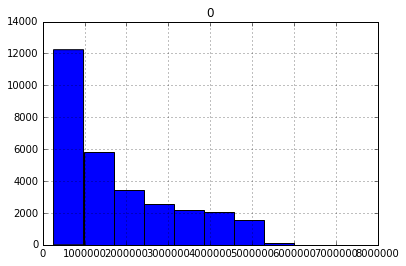

In [82]:
dur_zoom.hist()

#### 活跃时间大于七天的分布

In [79]:
dur_zoom = pd.DataFrame(filter(lambda x: x>=86400*7,duration.values()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9fc06ca90>]], dtype=object)

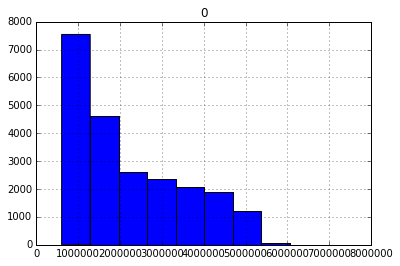

In [80]:
dur_zoom.hist()

#### 活跃时间大于十四天的分布

In [87]:
dur_zoom = pd.DataFrame(filter(lambda x: x>=86400*14,duration.values()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9f17b7e90>]], dtype=object)

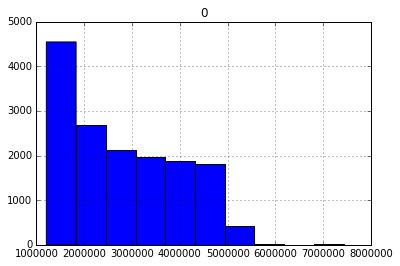

In [88]:
dur_zoom.hist()

#### 活跃时间大于三十天的分布

In [84]:
dur_zoom = pd.DataFrame(filter(lambda x: x>=86400*30,duration.values()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9fc021710>]], dtype=object)

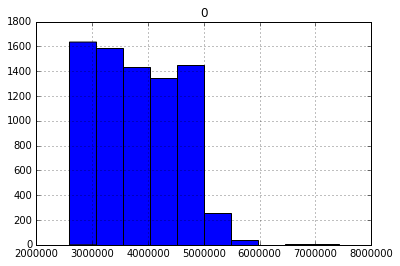

In [85]:
dur_zoom.hist()

In [39]:
for each in whole_dict_3[0].keys():
    if len(whole_dict_3[0][each])<1:
        del whole_dict_3[0][each]

In [40]:
len(whole_dict_3[0])

98999

In [37]:
for each in whole_dict_3[0].keys():
    boundary = max(map(lambda x: x[1], whole_dict_3[0][each])) - period
    whole_dict_3[0][each] = filter(lambda x: x[1] >= boundary, whole_dict_3[0][each])

In [43]:
whole_dict_3_normalized = {0:{}, 1:{}}
for each in whole_dict_3[0].keys():
    boundary = max(map(lambda x: x[1], whole_dict_3[0][each]))
    whole_dict_3_normalized[0][each] = map(lambda x: x[1]-boundary, whole_dict_3[0][each])

In [70]:
save_obj(whole_dict_3, 'whole_dict_3')

In [71]:
save_obj(whole_dict_3_normalized, 'whole_dict_3_normalized')

In [5]:
labels = {0:{}, 1:{}}
#for each period

for uuid in whole_dict[0]:
    # check if the uuid appears in the next period, if yes-> stay; no-> churn
    if uuid in whole_dict[1]:
        labels[0][uuid] = 0
    else:
        labels[0][uuid] = 1

In [6]:
sum(labels[0].values())

89564

In [2]:
whole_dict = load_obj('whole_dict_3')

In [7]:
features = []
num_handcraft_feature = 71
i = 0
for uuid in whole_dict[i]:
    row = np.zeros(len(eventids) + num_handcraft_feature)

    # label
    row[0] = labels[i][uuid]

    times = []
    for each in whole_dict[i][uuid]:
        eid = each[0]
        ts = each[1]
        idx = eventids.index(eid)
        # [0] - [len(eventid)] event feature
        row[idx + 1] += 1
        times.append(ts)

    # add handcraft features here
    """time features"""
    row[len(eventids) + 1] = max(times)
    row[len(eventids) + 2] = min(times)
    row[len(eventids) + 3] = max(times) - min(times)
    row[len(eventids) + 4] = np.percentile(times, 50)
    row[len(eventids) + 5] = np.std(times)
    # idle span and more
    row[len(eventids) + 6] = (time_start + period*(i+1)) - max(times)
    row[len(eventids) + 7] = min(times) - (time_start + period*(i))
    row[len(eventids) + 8] = (time_start + period*(i+1)) - np.percentile(times, 50)

    # userbase integrated time features
    try:
        row[len(eventids) +  9] = max(times) - user_dict[uuid][10]
        row[len(eventids) + 10] = max(times) - user_dict[uuid][11]
        row[len(eventids) + 11] = max(times) - user_dict[uuid][13]
        row[len(eventids) + 12] = min(times) - user_dict[uuid][10]
        row[len(eventids) + 13] = min(times) - user_dict[uuid][11]
        row[len(eventids) + 14] = min(times) - user_dict[uuid][13]
        row[len(eventids) + 15] = np.percentile(times, 50) - user_dict[uuid][10]
        row[len(eventids) + 16] = np.percentile(times, 50) - user_dict[uuid][11]
        row[len(eventids) + 17] = np.percentile(times, 50) - user_dict[uuid][13]
        row[len(eventids) + 18] = (time_start + period*(i+1)) - user_dict[uuid][10]
        row[len(eventids) + 19] = (time_start + period*(i+1)) - user_dict[uuid][13]
        row[len(eventids) + 20] = (time_start + period*(i)) - user_dict[uuid][11]
    except:
        row[len(eventids) + 9 : len(eventids) + 21] = np.nan

    # expenditure integrated time features
    try:
        row[len(eventids) + 21] = max(times) - exp_dict[uuid][6]
        row[len(eventids) + 22] = max(times) - exp_dict[uuid][7]
        row[len(eventids) + 23] = max(times) - exp_dict[uuid][9]
        row[len(eventids) + 24] = min(times) - exp_dict[uuid][6]
        row[len(eventids) + 25] = min(times) - exp_dict[uuid][7]
        row[len(eventids) + 26] = min(times) - exp_dict[uuid][9]
        row[len(eventids) + 27] = np.percentile(times, 50) - user_dict[uuid][6]
        row[len(eventids) + 28] = np.percentile(times, 50) - user_dict[uuid][7]
        row[len(eventids) + 29] = np.percentile(times, 50) - user_dict[uuid][9]
        row[len(eventids) + 30] = (time_start + period*(i+1)) - user_dict[uuid][6]
        row[len(eventids) + 31] = (time_start + period*(i+1)) - user_dict[uuid][9]
        row[len(eventids) + 32] = (time_start + period*(i)) - user_dict[uuid][7]
    except:
        row[len(eventids) + 21 : len(eventids) + 33] = np.nan

    try:
        row[len(eventids) + 33] = max(times) - exp_dict[uuid][18]
        row[len(eventids) + 34] = max(times) - exp_dict[uuid][19]
        row[len(eventids) + 35] = max(times) - exp_dict[uuid][21]
        row[len(eventids) + 36] = max(times) - exp_dict[uuid][18]
        row[len(eventids) + 37] = max(times) - exp_dict[uuid][19]
        row[len(eventids) + 38] = max(times) - exp_dict[uuid][21]
        row[len(eventids) + 39] = np.percentile(times, 50) - user_dict[uuid][18]
        row[len(eventids) + 40] = np.percentile(times, 50) - user_dict[uuid][19]
        row[len(eventids) + 41] = np.percentile(times, 50) - user_dict[uuid][21]
        row[len(eventids) + 42] = (time_start + period*(i+1)) - user_dict[uuid][18]
        row[len(eventids) + 43] = (time_start + period*(i+1)) - user_dict[uuid][21]
        row[len(eventids) + 44] = (time_start + period*(i)) - user_dict[uuid][19]
    except:
        row[len(eventids) + 33 : len(eventids) + 45] = np.nan

    try:
        row[len(eventids) + 45] = max(times) - exp_dict[uuid][29]
        row[len(eventids) + 46] = max(times) - exp_dict[uuid][30]
        row[len(eventids) + 47] = max(times) - exp_dict[uuid][32]
        row[len(eventids) + 48] = max(times) - exp_dict[uuid][29]
        row[len(eventids) + 49] = max(times) - exp_dict[uuid][30]
        row[len(eventids) + 50] = max(times) - exp_dict[uuid][32]
        row[len(eventids) + 51] = np.percentile(times, 50) - user_dict[uuid][29]
        row[len(eventids) + 52] = np.percentile(times, 50) - user_dict[uuid][30]
        row[len(eventids) + 53] = np.percentile(times, 50) - user_dict[uuid][32]
        row[len(eventids) + 54] = (time_start + period*(i+1)) - user_dict[uuid][29]
        row[len(eventids) + 55] = (time_start + period*(i+1)) - user_dict[uuid][32]
        row[len(eventids) + 56] = (time_start + period*(i)) - user_dict[uuid][30]
    except:
        row[len(eventids) + 45 : len(eventids) + 57] = np.nan

    """Event features"""
    # [57+] #events
    row[len(eventids) + 57] = len(whole_dict[i][uuid])
    # break into 2 bins
    row[len(eventids) + 58] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+0.5)), whole_dict[i][uuid]))
    row[len(eventids) + 59] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.5)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))
    # break into 4 bins
    row[len(eventids) + 60] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+0.25)), whole_dict[i][uuid]))
    row[len(eventids) + 61] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.25)) and x[1] < (time_start + period*(i+0.5)), whole_dict[i][uuid]))
    row[len(eventids) + 62] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.5)) and x[1] < (time_start + period*(i+0.75)), whole_dict[i][uuid]))
    row[len(eventids) + 63] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.75)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))
    # break into 7 bins
    row[len(eventids) + 64] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+1/7.0)), whole_dict[i][uuid]))
    row[len(eventids) + 65] = len(filter(lambda x: x[1] >= (time_start + period*(i+1/7.0)) and x[1] < (time_start + period*(i+2/7.0)), whole_dict[i][uuid]))
    row[len(eventids) + 66] = len(filter(lambda x: x[1] >= (time_start + period*(i+2/7.0)) and x[1] < (time_start + period*(i+3/7.0)), whole_dict[i][uuid]))
    row[len(eventids) + 67] = len(filter(lambda x: x[1] >= (time_start + period*(i+3/7.0)) and x[1] < (time_start + period*(i+4/7.0)), whole_dict[i][uuid]))
    row[len(eventids) + 68] = len(filter(lambda x: x[1] >= (time_start + period*(i+4/7.0)) and x[1] < (time_start + period*(i+5/7.0)), whole_dict[i][uuid]))
    row[len(eventids) + 69] = len(filter(lambda x: x[1] >= (time_start + period*(i+5/7.0)) and x[1] < (time_start + period*(i+6/7.0)), whole_dict[i][uuid]))
    row[len(eventids) + 70] = len(filter(lambda x: x[1] >= (time_start + period*(i+6/7.0)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))

    """features.append(row)"""
    features.append((uuid, row))

In [2]:
whole_dict = load_obj('whole_dict_2')

In [3]:
exp_dict = load_obj('expenditure_dict_2')

In [4]:
user_dict = load_obj('userbase_dict_2')

In [57]:
range(n_period - 1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [5]:
def get_labels(whole_dict):

    # creating labels for churn = 1, stay = 0
    labels = {i : {} for i in range(n_period)}
    #for each period
    for i in range(n_period - 1):
        # for each uuid
        for uuid in whole_dict[i]:
            # check if the uuid appears in the next period, if yes-> stay; no-> churn
            if uuid in whole_dict[i + 1]:
                labels[i][uuid] = 0
            else:
                labels[i][uuid] = 1

    return labels

In [6]:
labels = get_labels(whole_dict)

In [7]:
eventids = get_eventids('/data/yulun/timeline/timeline_event_gpapp.txt')

In [62]:
len(eventids)

199

In [131]:
len(whole_dict)

13

In [48]:
features = []
num_handcraft_feature = 71
for i in range(n_period - 2):
    for uuid in whole_dict[i]:
        row = np.zeros(len(eventids) + num_handcraft_feature)

        # label
        row[0] = labels[i][uuid]

        times = []
        for each in whole_dict[i][uuid]:
            eid = each[0]
            ts = each[1]
            idx = eventids.index(eid)
            # [0] - [len(eventid)] event feature
            row[idx + 1] += 1
            times.append(ts)

        # add handcraft features here
        """time features"""
        row[len(eventids) + 1] = max(times)
        row[len(eventids) + 2] = min(times)
        row[len(eventids) + 3] = max(times) - min(times)
        row[len(eventids) + 4] = np.percentile(times, 50)
        row[len(eventids) + 5] = np.std(times)
        # idle span and more
        row[len(eventids) + 6] = (time_start + period*(i+1)) - max(times)
        row[len(eventids) + 7] = min(times) - (time_start + period*(i))
        row[len(eventids) + 8] = (time_start + period*(i+1)) - np.percentile(times, 50)

        # userbase integrated time features
        try:
            row[len(eventids) +  9] = max(times) - user_dict[uuid][10]
            row[len(eventids) + 10] = max(times) - user_dict[uuid][11]
            row[len(eventids) + 11] = max(times) - user_dict[uuid][13]
            row[len(eventids) + 12] = min(times) - user_dict[uuid][10]
            row[len(eventids) + 13] = min(times) - user_dict[uuid][11]
            row[len(eventids) + 14] = min(times) - user_dict[uuid][13]
            row[len(eventids) + 15] = np.percentile(times, 50) - user_dict[uuid][10]
            row[len(eventids) + 16] = np.percentile(times, 50) - user_dict[uuid][11]
            row[len(eventids) + 17] = np.percentile(times, 50) - user_dict[uuid][13]
            row[len(eventids) + 18] = (time_start + period*(i+1)) - user_dict[uuid][10]
            row[len(eventids) + 19] = (time_start + period*(i+1)) - user_dict[uuid][13]
            row[len(eventids) + 20] = (time_start + period*(i)) - user_dict[uuid][11]
        except:
            row[len(eventids) + 9 : len(eventids) + 21] = np.nan

        # expenditure integrated time features
        try:
            row[len(eventids) + 21] = max(times) - exp_dict[uuid][6]
            row[len(eventids) + 22] = max(times) - exp_dict[uuid][7]
            row[len(eventids) + 23] = max(times) - exp_dict[uuid][9]
            row[len(eventids) + 24] = min(times) - exp_dict[uuid][6]
            row[len(eventids) + 25] = min(times) - exp_dict[uuid][7]
            row[len(eventids) + 26] = min(times) - exp_dict[uuid][9]
            row[len(eventids) + 27] = np.percentile(times, 50) - user_dict[uuid][6]
            row[len(eventids) + 28] = np.percentile(times, 50) - user_dict[uuid][7]
            row[len(eventids) + 29] = np.percentile(times, 50) - user_dict[uuid][9]
            row[len(eventids) + 30] = (time_start + period*(i+1)) - user_dict[uuid][6]
            row[len(eventids) + 31] = (time_start + period*(i+1)) - user_dict[uuid][9]
            row[len(eventids) + 32] = (time_start + period*(i)) - user_dict[uuid][7]
        except:
            row[len(eventids) + 21 : len(eventids) + 33] = np.nan

        try:
            row[len(eventids) + 33] = max(times) - exp_dict[uuid][18]
            row[len(eventids) + 34] = max(times) - exp_dict[uuid][19]
            row[len(eventids) + 35] = max(times) - exp_dict[uuid][21]
            row[len(eventids) + 36] = max(times) - exp_dict[uuid][18]
            row[len(eventids) + 37] = max(times) - exp_dict[uuid][19]
            row[len(eventids) + 38] = max(times) - exp_dict[uuid][21]
            row[len(eventids) + 39] = np.percentile(times, 50) - user_dict[uuid][18]
            row[len(eventids) + 40] = np.percentile(times, 50) - user_dict[uuid][19]
            row[len(eventids) + 41] = np.percentile(times, 50) - user_dict[uuid][21]
            row[len(eventids) + 42] = (time_start + period*(i+1)) - user_dict[uuid][18]
            row[len(eventids) + 43] = (time_start + period*(i+1)) - user_dict[uuid][21]
            row[len(eventids) + 44] = (time_start + period*(i)) - user_dict[uuid][19]
        except:
            row[len(eventids) + 33 : len(eventids) + 45] = np.nan

        try:
            row[len(eventids) + 45] = max(times) - exp_dict[uuid][29]
            row[len(eventids) + 46] = max(times) - exp_dict[uuid][30]
            row[len(eventids) + 47] = max(times) - exp_dict[uuid][32]
            row[len(eventids) + 48] = max(times) - exp_dict[uuid][29]
            row[len(eventids) + 49] = max(times) - exp_dict[uuid][30]
            row[len(eventids) + 50] = max(times) - exp_dict[uuid][32]
            row[len(eventids) + 51] = np.percentile(times, 50) - user_dict[uuid][29]
            row[len(eventids) + 52] = np.percentile(times, 50) - user_dict[uuid][30]
            row[len(eventids) + 53] = np.percentile(times, 50) - user_dict[uuid][32]
            row[len(eventids) + 54] = (time_start + period*(i+1)) - user_dict[uuid][29]
            row[len(eventids) + 55] = (time_start + period*(i+1)) - user_dict[uuid][32]
            row[len(eventids) + 56] = (time_start + period*(i)) - user_dict[uuid][30]
        except:
            row[len(eventids) + 45 : len(eventids) + 57] = np.nan

        """Event features"""
        # [57+] #events
        row[len(eventids) + 57] = len(whole_dict[i][uuid])
        # break into 2 bins
        row[len(eventids) + 58] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+0.5)), whole_dict[i][uuid]))
        row[len(eventids) + 59] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.5)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))
        # break into 4 bins
        row[len(eventids) + 60] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+0.25)), whole_dict[i][uuid]))
        row[len(eventids) + 61] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.25)) and x[1] < (time_start + period*(i+0.5)), whole_dict[i][uuid]))
        row[len(eventids) + 62] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.5)) and x[1] < (time_start + period*(i+0.75)), whole_dict[i][uuid]))
        row[len(eventids) + 63] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.75)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))
        # break into 7 bins
        row[len(eventids) + 64] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+1/7.0)), whole_dict[i][uuid]))
        row[len(eventids) + 65] = len(filter(lambda x: x[1] >= (time_start + period*(i+1/7.0)) and x[1] < (time_start + period*(i+2/7.0)), whole_dict[i][uuid]))
        row[len(eventids) + 66] = len(filter(lambda x: x[1] >= (time_start + period*(i+2/7.0)) and x[1] < (time_start + period*(i+3/7.0)), whole_dict[i][uuid]))
        row[len(eventids) + 67] = len(filter(lambda x: x[1] >= (time_start + period*(i+3/7.0)) and x[1] < (time_start + period*(i+4/7.0)), whole_dict[i][uuid]))
        row[len(eventids) + 68] = len(filter(lambda x: x[1] >= (time_start + period*(i+4/7.0)) and x[1] < (time_start + period*(i+5/7.0)), whole_dict[i][uuid]))
        row[len(eventids) + 69] = len(filter(lambda x: x[1] >= (time_start + period*(i+5/7.0)) and x[1] < (time_start + period*(i+6/7.0)), whole_dict[i][uuid]))
        row[len(eventids) + 70] = len(filter(lambda x: x[1] >= (time_start + period*(i+6/7.0)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))

        """features.append(row)"""
        features.append((uuid, row))

KeyError: '56f5d9f4dd4b4323b0e041149e36a5c2'

In [10]:
import datetime
print datetime.datetime.now()

2016-07-28 15:29:12.799213


In [11]:
len(features[0][1])

270

In [54]:
len(user_dict['3a5ff05feea2f8ae5e888f7d34c02be7'])

144

In [55]:
len(exp_dict['3a5ff05feea2f8ae5e888f7d34c02be7'])

34

In [11]:
    ret = []
    for each in features:
        temp = each[1].tolist()
        if each[0] in user_dict:
            temp += user_dict[each[0]]
        else:
            temp += ([np.nan]*144)
        if each[0] in exp_dict:
            temp += exp_dict[each[0]]
        else:
            temp += ([np.nan]*34)
        ret.append(temp)

In [12]:
len(ret)

98999

In [61]:
del user_dict
del whole_dict
del exp_dict
del ret
del features

In [65]:
del whole_dict

In [62]:
del exp_dict

In [63]:
del ret

In [67]:
del features

In [13]:
final = pd.DataFrame(ret)

In [26]:
save_obj(final, 'final')

In [118]:
len(ret)

150082

# ML stuffs start from here

In [3]:
final = load_obj('final')

In [14]:
final[274] = final[274].map(lambda x: ['None', '0', '1', '2'].index(x) if x in ['None', '0', '1', '2'] else 0)

In [15]:
final[276] = final[276].map(lambda x: [ '0', '102', '101'].index(x) if x in [ '0', '102', '101'] else 1)

In [54]:
final[278].value_counts().head()
#col278 = final[278].map(lambda x: cleaning_filter(x, [ '0', '102', '101'], '102'))

100     20146
9689     2695
1891     1014
144       737
9683      663
Name: 278, dtype: int64

In [69]:
final.shape

(98999, 448)

In [16]:
indices = range(1, final.shape[1])

In [8]:
indices = range(1, 270)

In [9]:
#del indices[278]

In [17]:
data = final[indices]
target = final[0]

In [18]:
from sklearn.preprocessing import Imputer

In [19]:
imputer = Imputer()

In [20]:
data = imputer.fit_transform(data)

## no windows

In [21]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)

In [22]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=250).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [23]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.932878787879
0.719109538231
0.96365674907
0.945404303268
0.982627851207
Confusion Matrix: 
[[ 1703  2035]
 [  623 35239]]
false positive: 2035
false negative: 623


In [27]:
sum(target)/len(target)

0.90469600703037401

### First look

In [109]:
sum(target)/len(target)

0.69447801723461366

In [42]:
del final

In [14]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)

In [15]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=250).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [37]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.812882593
0.752330461525
0.870658439005
0.834672491354
0.909887181813
Confusion Matrix: 
[[ 9332  6358]
 [ 3179 32099]]
false positive: 6358
false negative: 3179


In [92]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.811391461309
0.750050091071
0.869733721797
0.83316457668
0.909660411588
Confusion Matrix: 
[[ 9264  6426]
 [ 3187 32091]]
false positive: 6426
false negative: 3187


### Feature selection

In [22]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [23]:
score = f_classif(data, target)

/usr/local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [275 276 277 278 279 281 291 309 336 350 396] are constant.
  UserWarning)


In [24]:
select = SelectKBest(f_classif, k = 300)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

In [25]:
data2.shape

(127418, 300)

In [95]:
select = SelectKBest(chi2, k = 100)
data3 = select.fit_transform(np.absolute(data), target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data3, target, test_size=0.4, random_state=0)

In [26]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=250).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.811391461309
0.750050091071
0.869733721797
0.83316457668
0.909660411588
Confusion Matrix: 
[[ 9264  6426]
 [ 3187 32091]]
false positive: 6426
false negative: 3187


### some feature tests

In [190]:
indices = range(300) + range(414,448)
#del indices[278]
del indices[199]
data = final[indices]
target = final[199]

In [191]:
imputer = Imputer()
data = imputer.fit_transform(data)

In [122]:
select = SelectKBest(f_classif, k = 20)
data3 = select.fit_transform(data, target)

In [192]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.3, loss='exponential', n_estimators = 300, max_features=15).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [193]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.888798920378
0.756538621625
0.93424832429
0.907245253778
0.962908133893
Confusion Matrix: 
[[ 2928  2394]
 [  902 23416]]
false positive: 2394
false negative: 902


# random search

#### search with full features

In [81]:
data.shape

(74099, 435)

In [21]:
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

In [74]:
param_grid = { 'loss': ['deviance', 'exponential'],
               'learning_rate':[0.1, 0.2, 0.8],
               'n_estimators':[100, 250, 500],
               'max_depth':[3, 7],
               'subsample':[0.2, 1.0],
               'max_features':[50, 100, 400],
               'random_state':[0],
             }

In [56]:
from scipy.stats import randint as sp_randint

In [22]:
from time import time

In [23]:
from operator import itemgetter
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print "Model with rank: {0}".format(i + 1)
        print "Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores))
        print "Parameters: {0}".format(score.parameters)

In [78]:
start = time()
clf = GradientBoostingClassifier()
grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=20)
grid_search.fit(data, target)
print time()-start
report(grid_search.grid_scores_)

22412.3390181
Model with rank: 1
Mean validation score: 0.895 (std: 0.001)
Parameters: {'loss': 'exponential', 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 0, 'max_features': 400, 'max_depth': 7}
Model with rank: 2
Mean validation score: 0.895 (std: 0.001)
Parameters: {'loss': 'deviance', 'learning_rate': 0.2, 'n_estimators': 500, 'subsample': 1.0, 'random_state': 0, 'max_features': 400, 'max_depth': 3}
Model with rank: 3
Mean validation score: 0.894 (std: 0.001)
Parameters: {'loss': 'deviance', 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 1.0, 'random_state': 0, 'max_features': 100, 'max_depth': 7}


#### search with 300 features selected

In [31]:
select = SelectKBest(f_classif, k = 100)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

In [18]:
data2.shape

(74099, 300)

In [19]:
param_grid = { 'loss': ['deviance', 'exponential'],
               'learning_rate':[0.1, 0.2, 0.3],
               'n_estimators':[100, 300, 500],
               'max_depth':[3, 7],
               'max_features':[50, 200, 300],
               'random_state':[0],
             }

In [24]:
start = time()
clf = GradientBoostingClassifier()
grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=20)
grid_search.fit(data2, target)
print time()-start
report(grid_search.grid_scores_)

23377.7111039
Model with rank: 1
Mean validation score: 0.897 (std: 0.001)
Parameters: {'loss': 'exponential', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0, 'max_features': 200, 'max_depth': 7}
Model with rank: 2
Mean validation score: 0.895 (std: 0.001)
Parameters: {'loss': 'exponential', 'learning_rate': 0.2, 'n_estimators': 300, 'random_state': 0, 'max_features': 50, 'max_depth': 3}
Model with rank: 3
Mean validation score: 0.894 (std: 0.002)
Parameters: {'loss': 'deviance', 'learning_rate': 0.2, 'n_estimators': 500, 'random_state': 0, 'max_features': 200, 'max_depth': 3}


#### search with 200 features selected

In [26]:
select = SelectKBest(f_classif, k = 200)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

In [27]:
data2.shape

(74099, 200)

In [28]:
param_grid = { 'loss': ['exponential'],
               'learning_rate':[0.1, 0.2],
               'n_estimators':[300, 500],
               'max_depth':[3, 7],
               'max_features':[50, 100, 200],
               'random_state':[0],
             }

In [29]:
start = time()
clf = GradientBoostingClassifier()
grid_search = RandomizedSearchCV(clf, param_distributions=param_grid)
grid_search.fit(data2, target)
print time()-start
report(grid_search.grid_scores_)

14224.9151268
Model with rank: 1
Mean validation score: 0.896 (std: 0.000)
Parameters: {'loss': 'exponential', 'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 0, 'max_features': 200, 'max_depth': 7}
Model with rank: 2
Mean validation score: 0.896 (std: 0.002)
Parameters: {'loss': 'exponential', 'learning_rate': 0.2, 'n_estimators': 500, 'random_state': 0, 'max_features': 100, 'max_depth': 3}
Model with rank: 3
Mean validation score: 0.896 (std: 0.002)
Parameters: {'loss': 'exponential', 'learning_rate': 0.2, 'n_estimators': 500, 'random_state': 0, 'max_features': 200, 'max_depth': 3}


In [1]:
from feature_extractor import *

In [8]:
final = feature_final(whole_dict, user_dict, exp_dict, labels, eventids)

MemoryError: 